<a href="https://colab.research.google.com/github/AurelSann/dotfiles/blob/master/classify_electrocardiograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Day 4 - Classify Electrocardiograms

### Exercise objectives:
- Discover a new type of application with temporal data
- Try different recurrent neural networks

<hr>
<hr>

We have seen that RNN are able to predict what happens after an observed sequence of data. Let's see here a different way of using RNN. Instead of predicting a value that occurs after the seen sequence, we will here classify the entire sequence itself, as if the whole sequence corresponds to a given category. 

# Data

The data corresponds to electrocardiograms (ECG), which are basically heart beats. Each sequence is therefore a sequence of amplitudes. These ECG are often used to observe heart malfunctions! In this dataset, there are 87554 heart beats and each corresponds to a heart beat type, from 0 to 4:
- 0 : Normal beat
- 1 : Supraventricular
- 2 : Ventricular
- 3 : Fusion
- 4 : Beats that cannot be classified


❓ **Question** ❓ Download the data from [here](https://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip), unzip them and read them thanks to the 
`np.load(path/to/data, allow_pickle=True).tolist()`

# Nouvelle section

❓ **Question** ❓ Plot one ECG for each category in the dataset to see what an ECG looks like

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np
X = np.load('drive/MyDrive/ECG_data/X.npy',allow_pickle=True).tolist()
y = np.load('drive/MyDrive/ECG_data/y.npy',allow_pickle=True).tolist()

❓ **Question** ❓ You have probably noticed that each sequence (each ECG) has a different length. To corroborate your observation, plot the distribution of the sequence lengths in the dataset.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


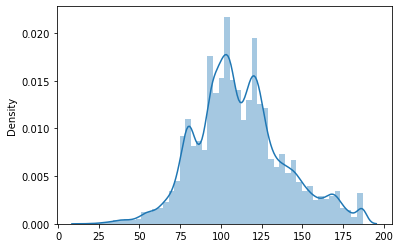

In [37]:
import seaborn as sns
sns.distplot([len(X[i]) for i in range(len(X))])



You remember that we pass a batch of data to the neural network. Thus, the tensor will have the following shape (batch_size, number of sequences, number of observations per sequence, size of each observation).

- The batch_size will be choosen in the model fit
- There are 87554 sequences
- Each observation is of size 1

However, the number of observations per sequence vary from one sequence to another. For computational reasons, this cannot be feed into a RNN. For that reason, you need to "fill in the blanks" thanks to the `pad_sequences` so that each sequence is filled with fake values. The resulting sequences will all be of the same length.


❓ **Question** ❓ Use the `pad_sequences` function on X directly (without extra arguments here), store the result in `X_pad` and print the first sequence.

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_pad = pad_sequences(X, dtype='float32',value =-1,padding='post') 
X_pad

array([[ 0.97794116,  0.9264706 ,  0.6813725 , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.96011394,  0.8632479 ,  0.46153846, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.        ,  0.6594595 ,  0.18648648, ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.90612245,  0.6244898 ,  0.59591836, ..., -1.        ,
        -1.        , -1.        ],
       [ 0.85822785,  0.6455696 ,  0.8455696 , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.90150636,  0.84588647,  0.80069524, ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)

❓ **Question** ❓ You probably see that the returned sequence is composed only of 0's. The reason is because, by default, `pad_sequences` returns integers. If a float is between 0.0 and 0.99999, it is converted to 0. To change this default behavior, turn the `dtype` argument of `pad_sequences` to `float32`. Pad once again the sequences, store the new result in `X_pad` and print the first sequence.

In [39]:
import numpy as np
X_pad=np.expand_dims(X_pad,axis=-1)
assert(X_pad.shape == (87554, 187, 1))

In [50]:
X_pad

array([[[ 0.97794116],
        [ 0.9264706 ],
        [ 0.6813725 ],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 0.96011394],
        [ 0.8632479 ],
        [ 0.46153846],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 1.        ],
        [ 0.6594595 ],
        [ 0.18648648],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       ...,

       [[ 0.90612245],
        [ 0.6244898 ],
        [ 0.59591836],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 0.85822785],
        [ 0.6455696 ],
        [ 0.8455696 ],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 0.90150636],
        [ 0.84588647],
        [ 0.80069524],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]]], dtype=float32)

The neural network, thanks to a `Masking` layer, will remove the 0 that you padded for computational reasons. 

**However**, if you look closely at the padded version of the first sequence, you have the padded zeros at the beginning of the sequence. But, also, there is a 0 value **_IN_** the heart-beat values. 
How could the neural network know which one to keep and which one to remove?

❓ **Question** ❓ Add the `value` keyword in the `pad_sequences` function to pad with values that **ARE NOT** in the initial dataset. Negative values for instance. Store it in `X_pad` and print the first sequence.

❗ **Remark** ❗ This is a good habit to pad the values **at the end** of the sequence (instead of the beginning as it is done by default). You can do that thanks to the `padding` keyword set to `post` (instead of `pre` by default).

[See full documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [40]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y)

❓ **Question** ❓ Plot the shape of `X_pad`

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(X_pad,y_cat,train_size=0.8)

In [51]:
type(X_pad)

numpy.ndarray

Remember that we said that the input data have to be of shape (number of sequences, number of observations per sequence, observation size) [Apart from the batch size dimention which will be automatically added by the Neural Network] ? Here, we only have the two first dimensions. This is because the last dimension is of size 1. 

❓ **Question** ❓ To remedy this issue, expand the last dimension thanks to the `np.expand_dims` function. 

❗ **Remark** ❗ The assert should not return any error ;)

In [42]:
### YOUD CODE HERE

assert(X_pad.shape == (87554, 187, 1))

❓ **Question** ❓ The labels `y` have to be one-hot encoded categories. For that reason, transform them to categories thanks to the appropriate Keras function and store the result in `y_cat`

In [55]:
X_train

array([[[ 0.8603696 ],
        [ 0.56057495],
        [ 0.16221766],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 1.        ],
        [ 0.9316667 ],
        [ 0.75333333],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 0.93786985],
        [ 0.8165681 ],
        [ 0.30473372],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       ...,

       [[ 0.8126411 ],
        [ 0.7325056 ],
        [ 0.41647854],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 1.        ],
        [ 0.8305785 ],
        [ 0.42975205],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 1.        ],
        [ 0.8996139 ],
        [ 0.63706565],
        ...,
        [-1.        ],
        [-1.        ],
        [-1.        ]]], dtype=float32)

❓ **Question** ❓ Split your data between a train and test set (80/20 ratio).

In [44]:
### YOUR CODE HERE

# Model

We will now write the Recurrent Neural Network

❓ **Question** ❓ Write model that has the following layers:
- a Masking layer whose `mask_value` corresponds to the value you decided to pad your data with (it is probably a negative value as suggested) - this layer will simply tell the network not to take into account the computation artifact
- a `SimpleRNN` layer with 10 units and the `tanh` as the activation function
- a dense layer with 20 units
- a last layer

# Nouvelle section

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking(mask_value=-1))
    model.add(layers.SimpleRNN(units=20, activation='tanh')) 
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dense(5,activation='softmax'))
    
    return model


In [57]:
model = init_model()

❓ **Question** ❓ Compile your model and train it - a very small patience equal to 2 should be sufficient. This is because you have a lot of sequences and thus, many optimizations per epochs. 

In [58]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
X_train.shape

(70043, 187, 1)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(X_train,y_train,
                   validation_split =0.2,
                   callbacks=[es],
                   epochs=300, 
                  batch_size=16,
                  verbose=1
                  )


Epoch 1/300
3503/3503 [==============================] - 171s 48ms/step - loss: 0.6813 - accuracy: 0.8233 - val_loss: 0.6542 - val_accuracy: 0.8303
Epoch 2/300
3503/3503 [==============================] - 164s 47ms/step - loss: 0.6662 - accuracy: 0.8250 - val_loss: 0.6539 - val_accuracy: 0.8303
Epoch 3/300
3503/3503 [==============================] - 158s 45ms/step - loss: 0.6559 - accuracy: 0.8289 - val_loss: 0.6492 - val_accuracy: 0.8303
Epoch 4/300
3503/3503 [==============================] - 162s 46ms/step - loss: 0.6607 - accuracy: 0.8277 - val_loss: 0.6496 - val_accuracy: 0.8303
Epoch 5/300
3503/3503 [==============================] - 159s 46ms/step - loss: 0.6632 - accuracy: 0.8267 - val_loss: 0.6545 - val_accuracy: 0.8303


❓ **Question** ❓ Evaluate your model on the test data.

In [61]:
model.evaluate(X_test,y_test)

548/548 [==============================] - 6s 12ms/step - loss: 0.6618 - accuracy: 0.8263


[0.6618326902389526, 0.8262805938720703]

### You should be have quite promising results with a test accuracy a little higher than 80%, which is a good result on a 5-class problem.

❓ **Question** ❓ Let's try to improve this result. Repeat the last steps by using a `LSTM` instead of a `SimpleRNN`. If you feel like it, you can change the neural network parameters to improve the accuracy. Evaluate your accuracy on the test set.

In [62]:
def init_model2():
    model = Sequential()
    model.add(layers.Masking(mask_value=-1))
    model.add(layers.LSTM(units=20, activation='tanh')) 
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dense(5,activation='softmax'))
    
    return model

In [64]:
model2 = init_model2()

In [67]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [68]:
history = model2.fit(X_train,y_train,
                   validation_split =0.2,
                   callbacks=[es],
                   epochs=300, 
                  batch_size=16,
                  verbose=1
                  )

Epoch 1/300
3503/3503 [==============================] - 289s 81ms/step - loss: 0.7726 - accuracy: 0.7868 - val_loss: 0.6524 - val_accuracy: 0.8303
Epoch 2/300
3503/3503 [==============================] - 285s 81ms/step - loss: 0.6661 - accuracy: 0.8251 - val_loss: 0.6485 - val_accuracy: 0.8303
Epoch 3/300
3503/3503 [==============================] - 287s 82ms/step - loss: 0.6631 - accuracy: 0.8263 - val_loss: 0.6487 - val_accuracy: 0.8303
Epoch 4/300
3503/3503 [==============================] - 286s 82ms/step - loss: 0.6514 - accuracy: 0.8302 - val_loss: 0.6484 - val_accuracy: 0.8303
Epoch 5/300
3503/3503 [==============================] - 284s 81ms/step - loss: 0.6656 - accuracy: 0.8251 - val_loss: 0.6484 - val_accuracy: 0.8303
Epoch 6/300
3503/3503 [==============================] - 286s 82ms/step - loss: 0.6533 - accuracy: 0.8294 - val_loss: 0.6484 - val_accuracy: 0.8303
Epoch 7/300
3503/3503 [==============================] - 281s 80ms/step - loss: 0.6727 - accuracy: 0.8222 - val_

Quite surprisingly, the LSTM is not much better than the SimpleRNN. What about a GRU?

❓ **Question** ❓ Build another model where you will use a GRU (instead of the LSTM or of the SimpleRNN), and the parameters are yours to choose. Report the test accuracy.

In [69]:
model2.evaluate(X_test,y_test)

548/548 [==============================] - 12s 22ms/step - loss: 0.6613 - accuracy: 0.8263


[0.6613496541976929, 0.8262805938720703]

Once again, the final accuracy is likely to be similar to the one you got previously, which might be a bit strange. To investigate these results, we will compare the results to a baseline model.

❓ **Question** ❓ What is the accuracy of a baseline model which would predict, for `y_test`, the most probable category in y_train.

In [ ]:
### YOUR CODE HERE

Basically, your RNNs are as good (bad?) as a model that predicts the most present category. The reason is probably because the RNNs really return only the most present category.

❓ **Question** ❓ Use the `predict` function on any of the previous model to see what are the different categories the model is predicting.

In [70]:
model2.predict(y_test[76])

array([[0.468283  , 0.12274607, 0.16973774, 0.05387805, 0.18535517],
       [0.4510793 , 0.12710065, 0.17174158, 0.06002973, 0.19004877],
       [0.4510793 , 0.12710065, 0.17174158, 0.06002973, 0.19004877],
       [0.4510793 , 0.12710065, 0.17174158, 0.06002973, 0.19004877],
       [0.4510793 , 0.12710065, 0.17174158, 0.06002973, 0.19004877]],
      dtype=float32)

Your models are returning the category which is the most present in your train set. 

A possibility here is to either subsample the data to have balanced classes in the training set. Another possibility is to do some data augmentation on temporal data. However, none of these methods would work right away. In fact, predicting the category of ECG data is not an easy task - also, you have only **one** heart-beat, no repetitions of them! 

Classifying ECG is actually quite a complex task. So let's move on to another exercise. 

**The lesson here is not to be satisfied with results until you have compare them to a baseline method.**